In [218]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import chi2

from matplotlib.patches import Patch


plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.style.use('default')
plt.rcParams.update({'font.size': 16})


# Read Data

In [2]:
# Read literature review data.

lit_review_data = pd.read_csv("lit_review_data.csv")
lit_review_data = clean_columns(lit_review_data)
lit_review_data


22 column names have been cleaned

,title,author,year,country,continent,climate,comparison,response,response_type,response_category,...,local_effect,landscape,landscape_gradient,minimum_complexity,maximum_complexity,landscape_effect,interaction_details,interaction_effect_simple,interaction_effect,description
0,A macro-scale perspective on within-farm manag...,Amano et al.,2011,Japan,Asia,NaN,Conventional,Spider abundance,Biodiversity,Natural enemy,...,Negative,The proportion of forest area surrounding the ...,"<20% forest, >20% forest",NaN,NaN,Positive,NS,NS,NS,A multilevel modelling approach revealed that ...
1,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Cicada species richness,Biodiversity,Arthropod,...,NS,The amount of seminatural habitat (forest edge...,3.6-25% semi-natural habitat,3.6,25.0,NS,NS,NS,NS,All other taxonomic groups showed no significa...
2,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Orthopteran species richness,Biodiversity,Arthropod,...,NS,The amount of seminatural habitat (forest edge...,3.6-25% semi-natural habitat,3.6,25.0,NS,NS,NS,NS,All other taxonomic groups showed no significa...
3,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Bee species richness,Biodiversity,Pollinator,...,NS,The amount of seminatural habitat (forest edge...,3.6-25% semi-natural habitat,3.6,25.0,Positive,NS,NS,NS,An increasing proportion of seminatural habita...
4,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Butterfly species richness,Biodiversity,Pollinator,...,NS,The amount of seminatural habitat (forest edge...,3.6-25% semi-natural habitat,3.6,25.0,NS,NS,NS,NS,All other taxonomic groups showed no significa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Abundance (wood-nesting bees),Biodiversity,Pollinator,...,NS,We analysed landscape cover as the proportion ...,3-64% woodland,3.0,64.0,NS,NS,NS,NS,The abundance of wood-nesting bees was associa...
577,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Wild bee visitation,Ecosystem services,Pollinator,...,NS,We analysed landscape cover as the proportion ...,3-64% woodland,3.0,64.0,NS,NS,NS,NS,"Similarly, no individual variables were strong..."
578,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Abundance (eusocial bees),Biodiversity,Pollinator,...,NS,We analysed landscape cover as the proportion ...,3-64% woodland,3.0,64.0,NS,NS,NS,NS,"Similarly, no individual variables were strong..."
579,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Abundance (solitary bees),Biodiversity,Pollinator,...,Positive,We analysed landscape cover as the proportion ...,3-64% woodland,3.0,64.0,NS,NS,NS,NS,The abundance of solitary bees showed little a...


In [3]:
# Convert column data types.

lit_review_data[
    [
        "title",
        "author",
        "country",
        "continent",
        "comparison",
        "response",
        "response_category",
        "local_factor",
        "local_strategy",
        "local_effect",
        "landscape",
        "landscape_effect",
        "interaction_effect",
        "response_type",
    ]
] = lit_review_data.loc[
    :,
    [
        "title",
        "author",
        "country",
        "continent",
        "comparison",
        "response",
        "response_category",
        "local_factor",
        "local_strategy",
        "local_effect",
        "landscape",
        "landscape_effect",
        "interaction_effect",
        "response_type",
    ],
].astype(
    "category"
)


In [4]:
lit_review_data.local_strategy.value_counts(ascending=True)


Structure     58
Diversity     73
Floral       139
Intensity    311
Name: local_strategy, dtype: int64

In [5]:
lit_review_data.response_category.value_counts(ascending=True)


Arthropod         32
Crop              69
Pest              74
Pollinator       120
Natural enemy    286
Name: response_category, dtype: int64

In [6]:
lit_review_data.response_type.value_counts(ascending=True)


Ecosystem services    227
Biodiversity          354
Name: response_type, dtype: int64

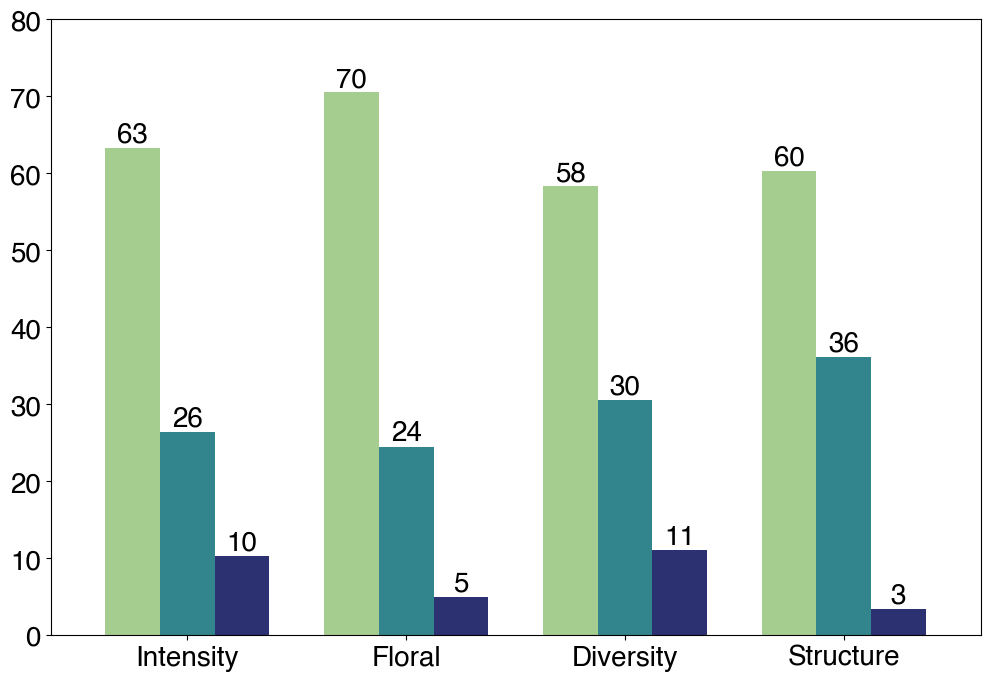

In [7]:
# Plotting local effects of local practices.

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax1 = (
    lit_review_data
    .groupby(["local_strategy"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Intensity', 'Floral', 'Diversity', 'Structure']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Local Management Practices",
        #ylabel="Percent of Observations",
        #xlabel="Local Management Practice Category",
        rot=0,
        figsize=(12, 8)
    )
)

for container in ax1.containers:
    ax1.bar_label(container, fontsize=20, fmt="%d")

#ax1.legend(title="Effect")

plt.xlabel(None)
plt.ylim(0,80)
ax1.get_legend().remove()


In [8]:
strategy_local_effect = (
    lit_review_data.groupby(["local_strategy"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

strategy_local_effect


local_strategy,Diversity,Floral,Intensity,Structure
local_effect,,,,
NS,58.3,70.5,63.3,60.3
Positive,30.6,24.5,26.4,36.2
Negative,11.1,5.0,10.3,3.4


In [9]:
stats.chisquare(strategy_local_effect)


Power_divergenceResult(statistic=array([33.7538    , 67.865     , 44.2982    , 48.99159159]), pvalue=array([4.68225927e-08, 1.83359110e-15, 2.40307924e-10, 2.29938162e-11]))

In [10]:
stats.chisquare(strategy_local_effect.T)


Power_divergenceResult(statistic=array([1.35784469, 2.74214104, 5.88590604]), pvalue=array([0.71544522, 0.4331133 , 0.11729503]))

In [11]:
stats.chi2_contingency(strategy_local_effect)


Chi2ContingencyResult(statistic=9.987209000186358, pvalue=0.1251917107477963, dof=6, expected_freq=array([[63.11577894, 63.11577894, 63.11577894, 63.05266317],
       [29.43235809, 29.43235809, 29.43235809, 29.40292573],
       [ 7.45186297,  7.45186297,  7.45186297,  7.4444111 ]]))

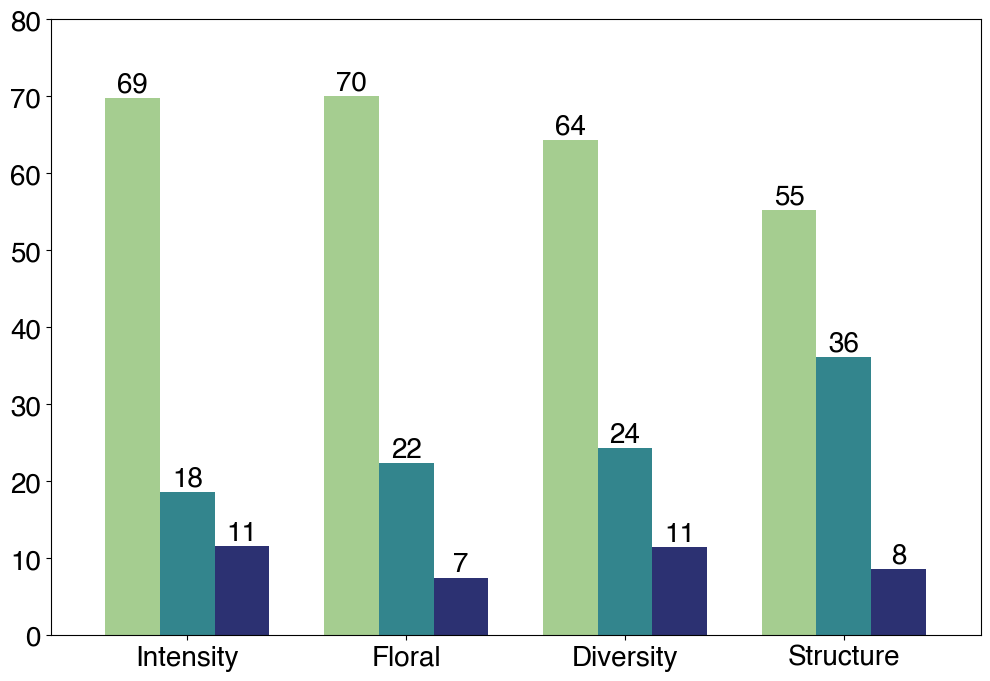

In [12]:
# Plotting effects of local practices across landscape gradients.
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax2 = (
    lit_review_data.groupby(["local_strategy"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Intensity', 'Floral', 'Diversity', 'Structure']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Landscape Complexity, Subset by Local Management",
        #ylabel="Percent of Observations",
        #xlabel="Local Management Practice Category",
        rot=0,
        figsize=(12, 8),
    )
)

for container in ax2.containers:
    ax2.bar_label(container, fontsize=20, fmt="%d")

plt.xlabel(None)
plt.ylim(0,80)
ax2.get_legend().remove()
#ax2.get_yaxis().set_ticks([])


#ax2.legend(title="Effect")


In [13]:
strategy_landscape_effect = (
    lit_review_data.groupby(["local_strategy"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

strategy_landscape_effect


local_strategy,Diversity,Floral,Intensity,Structure
landscape_effect,,,,
NS,64.3,70.1,69.8,55.2
Positive,24.3,22.4,18.6,36.2
Negative,11.4,7.5,11.6,8.6


In [14]:
stats.chisquare(strategy_landscape_effect)


Power_divergenceResult(statistic=array([45.6482, 64.1606, 60.5768, 32.9432]), pvalue=array([1.22354322e-10, 1.16869916e-14, 7.01318046e-14, 7.02222939e-08]))

In [15]:
stats.chisquare(strategy_landscape_effect.T)


Power_divergenceResult(statistic=array([2.24348497, 6.82118227, 1.28158568]), pvalue=array([0.52343405, 0.07782105, 0.73351031]))

In [16]:
stats.chi2_contingency(strategy_landscape_effect)


Chi2ContingencyResult(statistic=10.346252909063761, pvalue=0.11080763261496468, dof=6, expected_freq=array([[64.85 , 64.85 , 64.85 , 64.85 ],
       [25.375, 25.375, 25.375, 25.375],
       [ 9.775,  9.775,  9.775,  9.775]]))

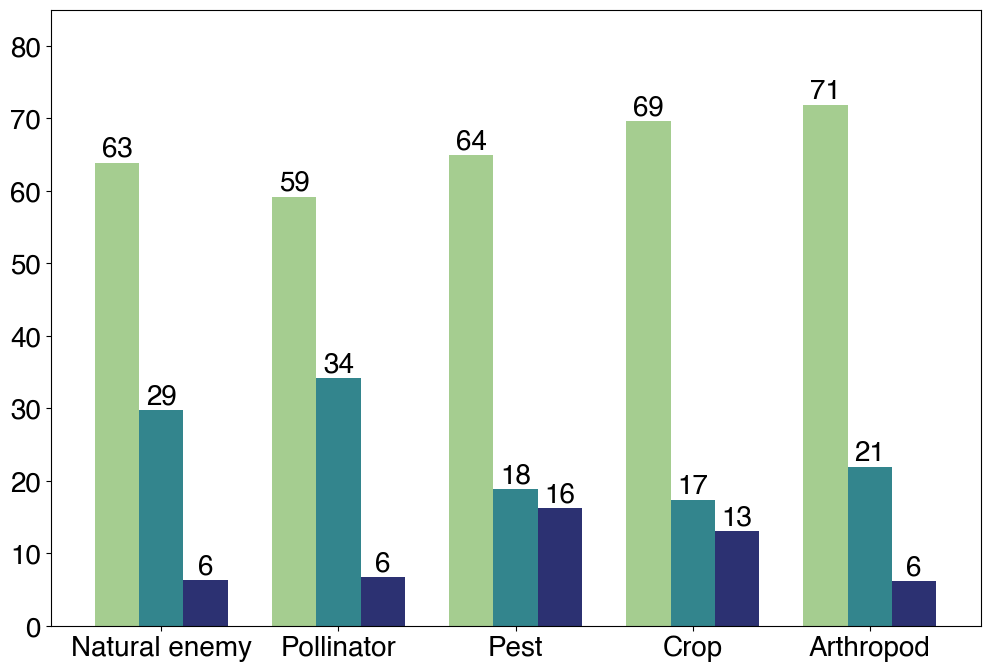

In [17]:
# Plotting effects of local practices for different response types.

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax3 = (
    lit_review_data.groupby(["response_category"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Natural enemy', 'Pollinator', 'Pest', 'Crop', 'Arthropod']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Local Management Practices, Subset by Response Category",
        #ylabel="Percent of Observations",
        #xlabel="Response Category",
        rot=0,
        figsize=(12, 8),
    )
)

for container in ax3.containers:
    ax3.bar_label(container, fontsize=20, fmt="%d")

plt.xlabel(None)
plt.ylim(0,85)
ax3.get_legend().remove()
#ax3.legend(title="Effect")


In [18]:
response_local_effect = (
    lit_review_data.groupby(["response_category"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
).T

response_local_effect


response_category,Arthropod,Crop,Natural enemy,Pest,Pollinator
local_effect,,,,,
NS,71.9,69.6,63.9,64.9,59.2
Positive,21.9,17.4,29.8,18.9,34.2
Negative,6.2,13.0,6.3,16.2,6.7


In [19]:
stats.chisquare(response_local_effect)


Power_divergenceResult(statistic=array([70.6298    , 59.4776    , 50.3282    , 44.9498    , 41.33366633]), pvalue=array([4.60186423e-16, 1.21507549e-13, 1.17861029e-11, 1.73490200e-10,
       1.05805537e-09]))

In [20]:
stats.chisquare(response_local_effect.T)


Power_divergenceResult(statistic=array([1.51107739, 8.6207856 , 8.87892562]), pvalue=array([0.82467745, 0.07130941, 0.06419805]))

In [21]:
stats.chi2_contingency(response_local_effect)


Chi2ContingencyResult(statistic=19.009019030638072, pvalue=0.01481148814479304, dof=8, expected_freq=array([[65.88682264, 65.88682264, 65.88682264, 65.88682264, 65.95270946],
       [24.43511298, 24.43511298, 24.43511298, 24.43511298, 24.45954809],
       [ 9.67806439,  9.67806439,  9.67806439,  9.67806439,  9.68774245]]))

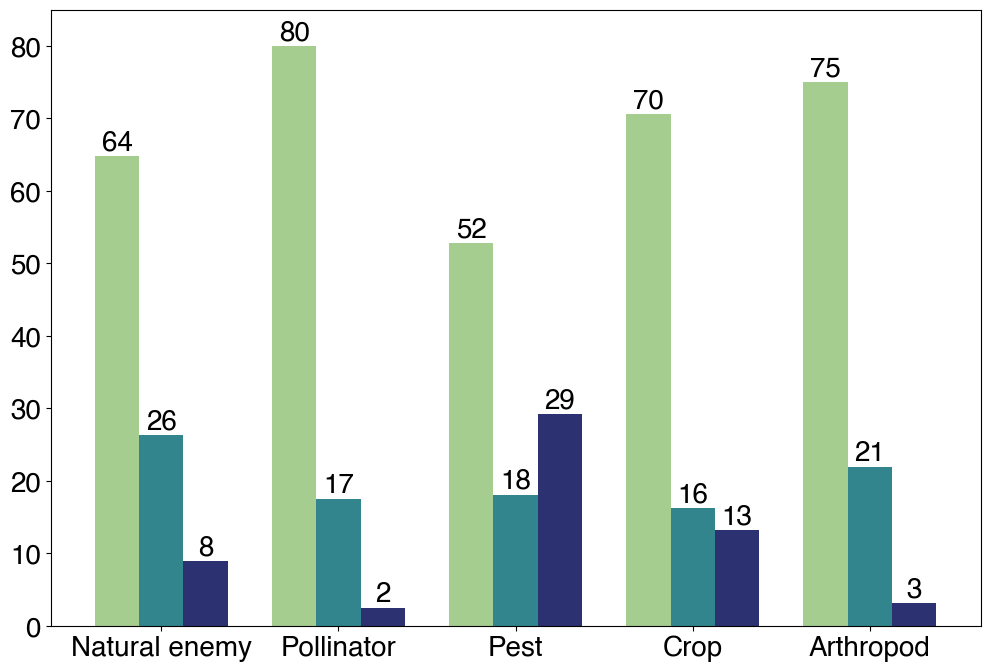

In [22]:
# Plotting effects of local practices across landscape gradients for different response types.

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax3 = (
    lit_review_data.groupby(["response_category"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Natural enemy', 'Pollinator', 'Pest', 'Crop', 'Arthropod']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Landscape Complexity, Subset by Response Category",
        #ylabel="Percent of Observations",
        #xlabel="Response Category",
        rot=0,
        figsize=(12, 8),
    )
)

for container in ax3.containers:
    ax3.bar_label(container, fontsize=20, fmt="%d")

plt.xlabel(None)
plt.ylim(0,85)
ax3.get_legend().remove()
#ax3.get_yaxis().set_ticks([])

#ax3.legend(title="Effect")


In [23]:
response_landscape_effect = (
    lit_review_data.groupby(["response_category"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

response_landscape_effect


response_category,Arthropod,Crop,Natural enemy,Pest,Pollinator
landscape_effect,,,,,
NS,75.0,70.6,64.8,52.8,80.0
Positive,21.9,16.2,26.3,18.1,17.5
Negative,3.1,13.2,8.9,29.2,2.5


In [24]:
stats.chisquare(response_landscape_effect)


Power_divergenceResult(statistic=array([ 83.4266    ,  62.6312    ,  49.0982    ,  18.82377622,
       101.375     ]), pvalue=array([7.65850478e-19, 2.51077458e-14, 2.18002430e-11, 8.17464551e-05,
       9.69836330e-23]))

In [25]:
stats.chisquare(response_landscape_effect.T)


Power_divergenceResult(statistic=array([ 6.3955711 ,  3.38      , 41.68963093]), pvalue=array([1.71490328e-01, 4.96357520e-01, 1.93446131e-08]))

In [26]:
stats.chi2_contingency(response_landscape_effect)


Chi2ContingencyResult(statistic=51.44370018481724, pvalue=2.15504769694293e-08, dof=8, expected_freq=array([[68.62627475, 68.62627475, 68.62627475, 68.69490102, 68.62627475],
       [19.9960008 , 19.9960008 , 19.9960008 , 20.0159968 , 19.9960008 ],
       [11.37772446, 11.37772446, 11.37772446, 11.38910218, 11.37772446]]))

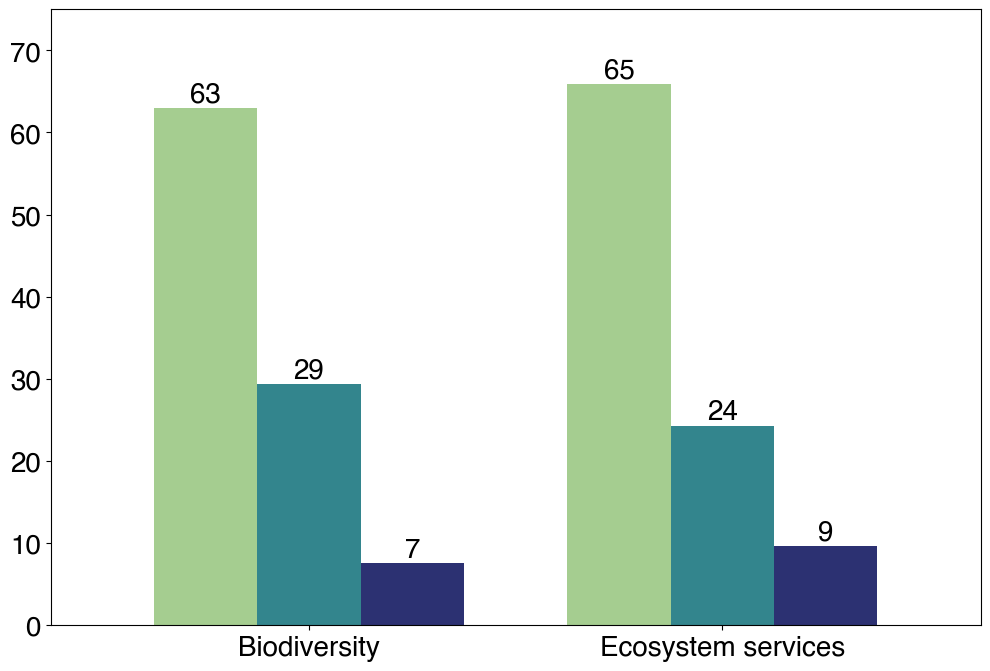

In [27]:
# Plotting local effects of local practices.
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax9 = (
    lit_review_data.groupby(["response_type"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Local Management on Response Type",
        #ylabel="Percent of Observations",
        #xlabel="Response Type",
        rot=0,
        figsize=(12, 8)
    )
)

plt.xlabel(None)
plt.ylim(0, 75)

for container in ax9.containers:
    ax9.bar_label(container, fontsize=20, fmt="%d")

ax9.get_legend().remove()
#ax9.legend(title="Effect")


In [28]:
response_type_local_effect = (
    lit_review_data.groupby(["response_type"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

response_type_local_effect


response_type,Biodiversity,Ecosystem services
local_effect,,
NS,63.0,65.9
Positive,29.4,24.3
Negative,7.6,9.7


In [29]:
stats.chisquare(response_type_local_effect)


Power_divergenceResult(statistic=array([46.7336    , 51.07267267]), pvalue=array([7.11095123e-11, 8.12288007e-12]))

In [30]:
stats.chisquare(response_type_local_effect.T)


Power_divergenceResult(statistic=array([0.06524438, 0.48435754, 0.25491329]), pvalue=array([0.79839117, 0.48645513, 0.61363653]))

In [31]:
stats.chi2_contingency(response_type_local_effect)


Chi2ContingencyResult(statistic=0.8044653884871102, pvalue=0.6688250958318906, dof=2, expected_freq=array([[64.48224112, 64.41775888],
       [26.86343172, 26.83656828],
       [ 8.65432716,  8.64567284]]))

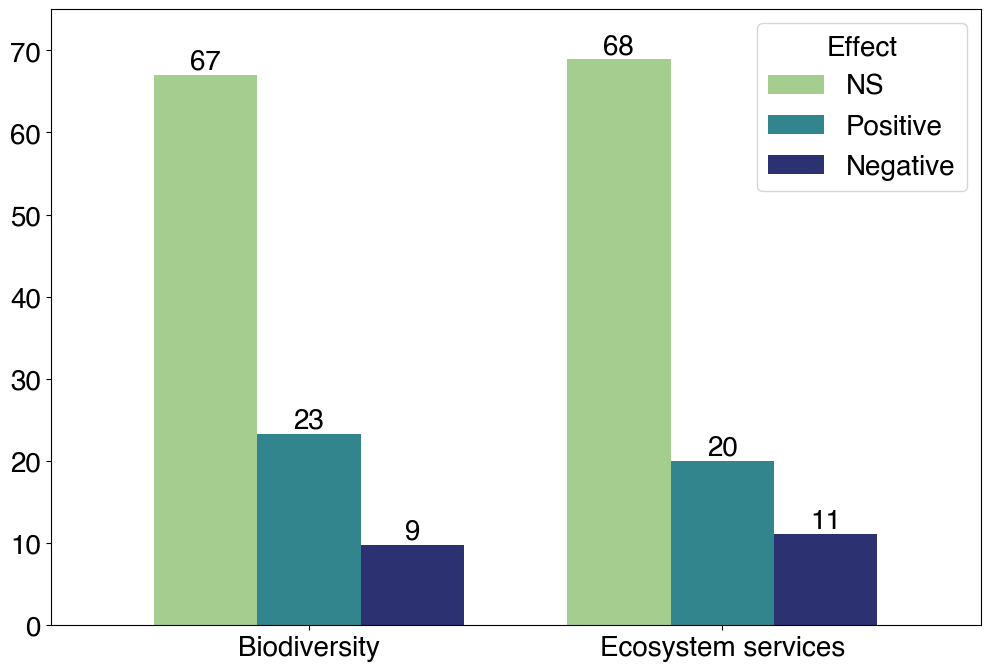

In [32]:
# Plotting local effects of local practices.
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax10 = (
    lit_review_data.groupby(["response_type"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Landscape Complexity on Response Type",
        #ylabel="Percent of Observations",
        #xlabel="Response Type",
        rot=0,
        figsize=(12, 8),
    )
)

plt.xlabel(None)
#ax10.get_yaxis().set_ticks([])
plt.ylim(0,75)

for container in ax10.containers:
    ax10.bar_label(container, fontsize=20, fmt="%d")

ax10.xaxis.labelpad = 100

ax10.legend(title="Effect")


In [33]:
response_type_landscape_effect = (
    lit_review_data.groupby(["response_type"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

response_type_landscape_effect


response_type,Biodiversity,Ecosystem services
landscape_effect,,
NS,67.0,68.9
Positive,23.3,20.0
Negative,9.8,11.1


In [34]:
stats.chisquare(response_type_landscape_effect)


Power_divergenceResult(statistic=array([53.58421578, 58.1126    ]), pvalue=array([2.31385097e-12, 2.40441399e-13]))

In [35]:
stats.chisquare(response_type_landscape_effect.T)


Power_divergenceResult(statistic=array([0.02656365, 0.25150115, 0.08086124]), pvalue=array([0.87053136, 0.61602005, 0.77613365]))

In [36]:
stats.chi2_contingency(response_type_landscape_effect)


Chi2ContingencyResult(statistic=0.3588761631129029, pvalue=0.8357396970423747, dof=2, expected_freq=array([[67.98395802, 67.91604198],
       [21.66081959, 21.63918041],
       [10.45522239, 10.44477761]]))

**Mako Color Hex Codes**

- '0B0405'  
- '357BA3'  
- 'DEF5E5'

In [37]:
lit_review_data.insert(
    loc=14,
    column="gradient_range",
    value=lit_review_data["maximum_complexity"] - lit_review_data["minimum_complexity"],
)


Text(0, 0.5, 'Number of observations')

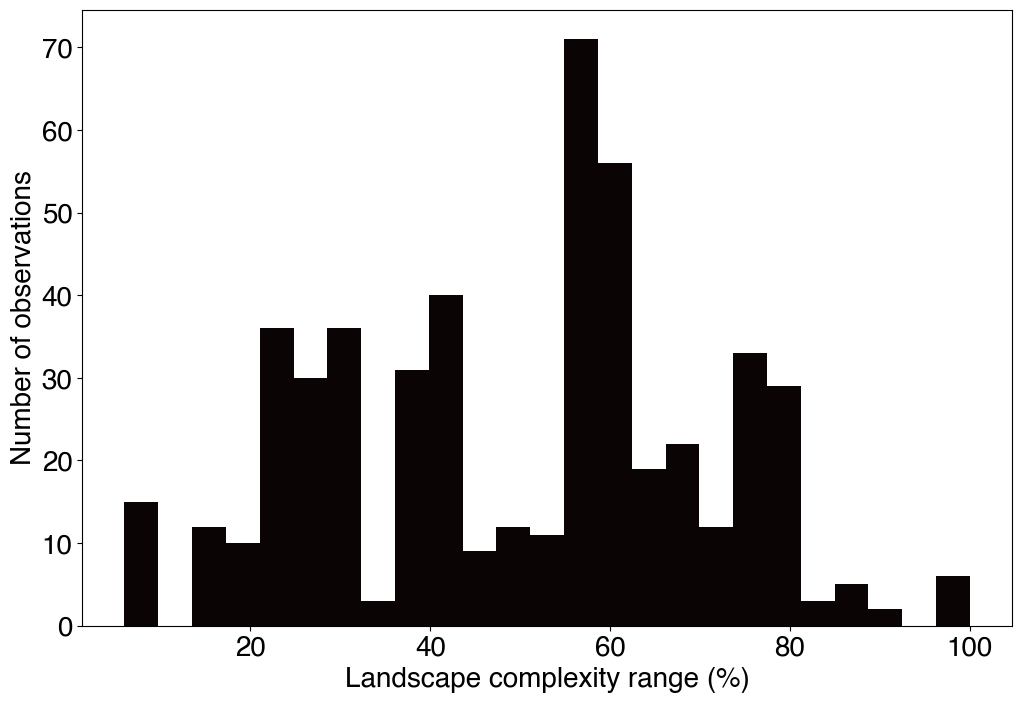

In [38]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(12, 8))
#plt.title("Distribution of landscape complexity ranges")

plt.hist(
    lit_review_data["gradient_range"], alpha=1, bins=25, color="#0B0405"
)

plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")


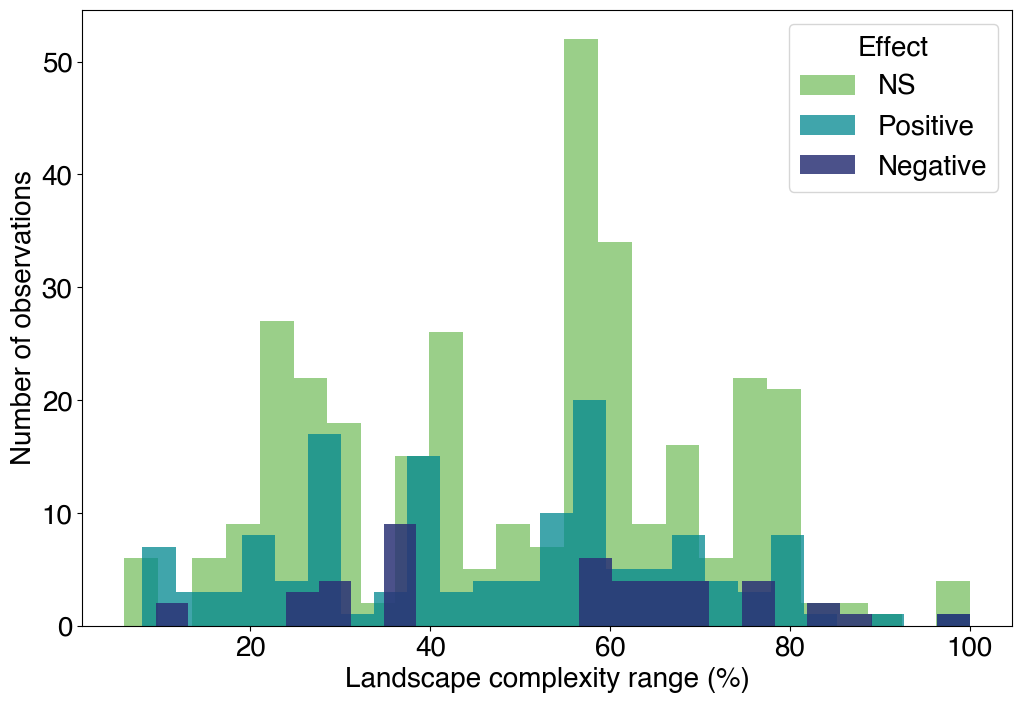

In [39]:
# Gradient ranges for local effect observations

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(12, 8))
#plt.title("Landscape Complexity Ranges for Local Effect Observations")

plt.hist(
    lit_review_data.where(lit_review_data["local_effect"] == "NS")["gradient_range"],
    alpha=1,
    label="NS",
    bins=25,
    color="#9ACF89",
)

plt.hist(
    lit_review_data.where(lit_review_data["local_effect"] == "Positive")[
        "gradient_range"
    ],
    alpha=0.75,
    label="Positive",
    bins=25,
    color="#00878F",
)

plt.hist(
    lit_review_data.where(lit_review_data["local_effect"] == "Negative")[
        "gradient_range"
    ],
    alpha=0.85,
    label="Negative",
    bins=25,
    color="#2B3276",
)

plt.legend(title="Effect", loc="upper right")
plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")
plt.show()


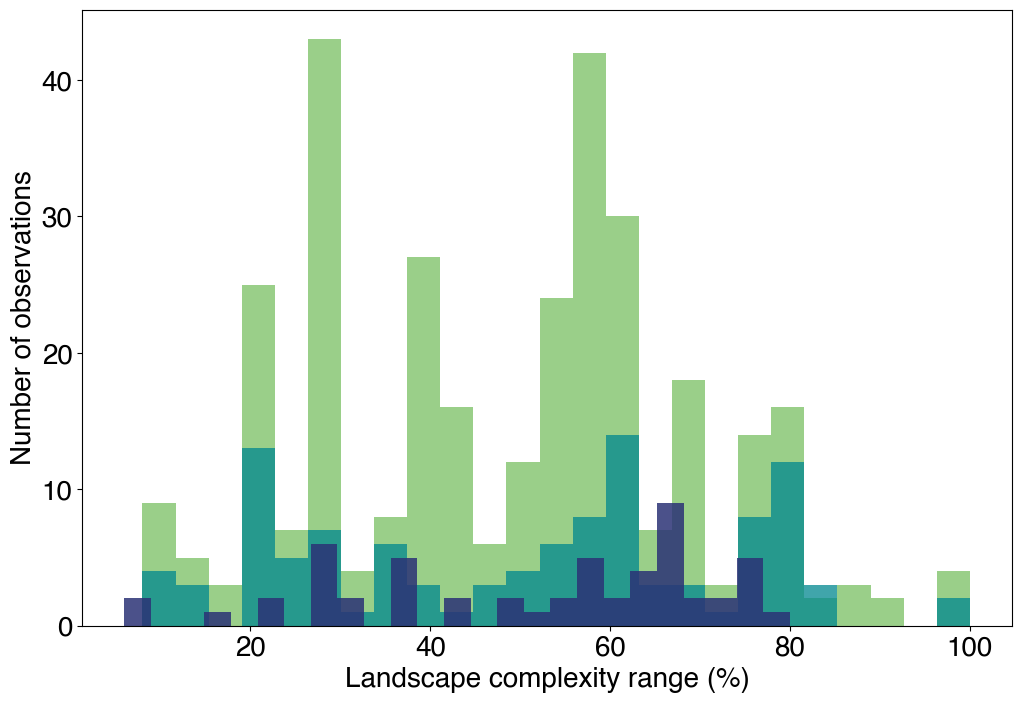

In [40]:
# Gradient ranges for landscape complexity effect observations

plt.figure(figsize=(12, 8))
#plt.title("Landscape Complexity Ranges for Landscape Complexity Effect Observations")

plt.hist(
    lit_review_data.where(lit_review_data["landscape_effect"] == "NS")[
        "gradient_range"
    ],
    alpha=1,
    label="NS",
    bins=25,
    color="#9ACF89",
)

plt.hist(
    lit_review_data.where(lit_review_data["landscape_effect"] == "Positive")[
        "gradient_range"
    ],
    alpha=0.75,
    label="Positive",
    bins=25,
    color="#00878F",
)

plt.hist(
    lit_review_data.where(lit_review_data["landscape_effect"] == "Negative")[
        "gradient_range"
    ],
    alpha=0.85,
    label="Negative",
    bins=25,
    color="#2B3276",
)

#plt.legend(title="Effect", loc="upper right")
plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")
plt.show()




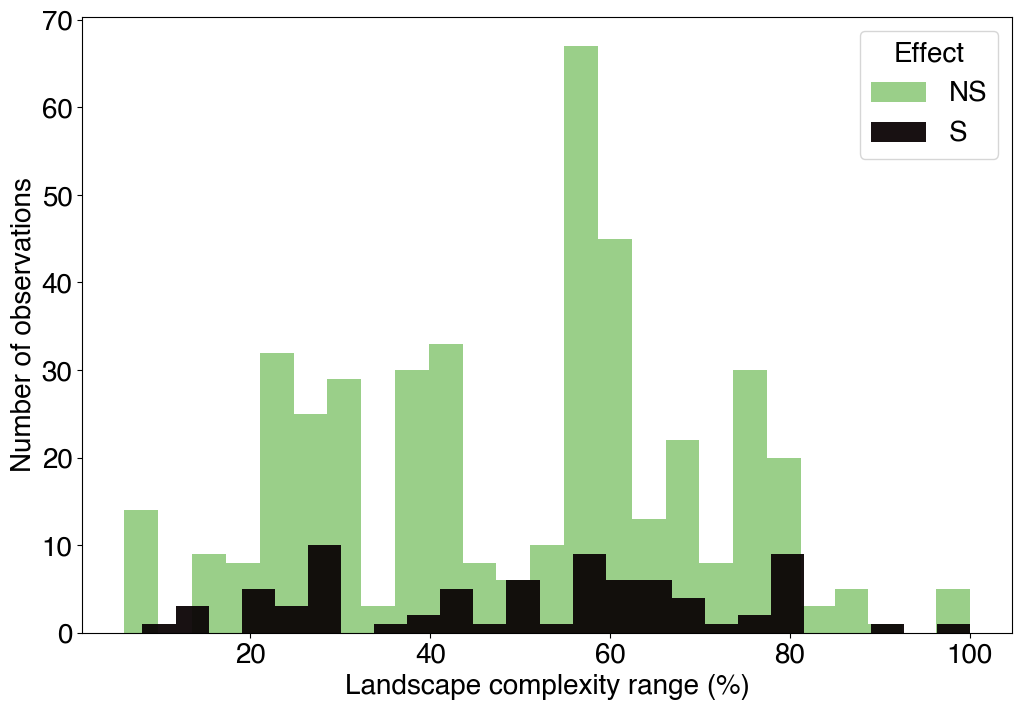

In [41]:
# Gradient ranges for interaction effect

plt.figure(figsize=(12, 8))
#plt.title("Landscape Complexity Ranges for Interaction Effect Observations")

plt.hist(
    lit_review_data.where(lit_review_data["interaction_effect"] == "NS")[
        "gradient_range"
    ],
    alpha=1,
    label="NS",
    bins=25,
    color="#9ACF89",
)

plt.hist(
    lit_review_data.where(lit_review_data["interaction_effect"] == "S")[
        "gradient_range"
    ],
    alpha=0.95,
    label="S",
    bins=25,
    color="#0B0405",
)

plt.legend(title="Effect", loc="upper right")
plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")
plt.show()


In [42]:
gradient_range_array = lit_review_data.gradient_range.sort_values(ascending=True)

gradient_range_array[np.logical_not(np.isnan(gradient_range_array))].value_counts()


57.87    24
80.00    24
30.00    23
28.00    22
55.00    22
         ..
53.40     1
51.00     1
47.00     1
32.80     1
6.00      1
Name: gradient_range, Length: 72, dtype: int64

In [43]:
interaction_data = pd.read_csv("lit_review_interactions.csv")
interaction_data


,Obs_ID,Title,Author,Year,Comparison,Response,Sample Size,Unit,Response Type,Response Category,...,Landscape Effect,Interaction Details,Interaction Effect,Simple_Collapsed,Intermediate_Collapsed,Complex_Collapsed,Simple,Intermediate,Complex,Description
0,Obs_1,Agricultural intensification and biodiversity ...,Flohre et al.,2011,Conventional,Beta diversity (carabids),1350,Fields,Biodiversity,Natural enemy,...,NS,Medium intensity has a negative effect on dive...,More negative local effect in complex landscapes,NP,NP,NP,NS,Negative,NS,β diversities of carabids were only decreased ...
1,Obs_2,Agricultural landscape composition affects the...,Gervais et al.,2020,Conventional,Pollen load diversity,80,Colonies,Ecosystem Services,Pollinator,...,NS,"Positive when local species richness was high,...",More positive local effect in complex landscapes,NP,Positive,Positive,Negative,Positive,Positive,Landscape composition as well as local floral ...
2,Obs_3,"Agroecological farming, flowering phenology an...",Monticelli et al.,2022,Control,Seed yield/plant C. segetum,114,Plants,Ecosystem Services,Crop,...,Positive,Positive effect of local factor in more comple...,More positive local effect in complex landscapes,NP,Positive,Positive,NS,Positive,Positive,C. segetum seed yield increased with flowering...
3,Obs_4,"Agroecological farming, flowering phenology an...",Monticelli et al.,2022,Control,Pollinator abundance C. segetum,16,Sites,Biodiversity,Pollinator,...,Negative,Positive effect of local factor in more simple...,More positive local effect in simple landscapes,Positive,Positive,NP,Positive,Positive,Negative,The abundance of pollinators on C. segetum rel...
4,Obs_5,"Agroecological farming, flowering phenology an...",Monticelli et al.,2022,Control,Pollinator abundance C. jacea,16,Sites,Biodiversity,Pollinator,...,NS,Positive effect of local factor in more simple...,More positive local effect in simple landscapes,Positive,NP,NP,Positive,Negative,Negative,A significant interaction revealed that C. seg...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Obs_79,The effect of organic farming on butterfly div...,Rundlof & Smith,2006,Conventional,Butterfly richness,12,Paired Fields,Biodiversity,Pollinator,...,Positive,More positive in homogenous ~30% non-arable land,More positive local effect in simple landscapes,Positive,NP,NP,Positive,NS,NS,Both species richness and abundance of butterf...
79,Obs_80,The effect of organic farming on butterfly div...,Rundlof & Smith,2006,Conventional,Butterfly abundance,12,Paired Fields,Biodiversity,Pollinator,...,Positive,More positive in homogenous ~30% non-arable land,More positive local effect in simple landscapes,Positive,NP,NP,Positive,NS,NS,Both species richness and abundance of butterf...
80,Obs_81,The taxon- and functional trait-dependent effe...,Zhang et al.,2020,Control,Abundance (spider),36,Fields,Biodiversity,Natural enemy,...,Negative,"Positive in grassy and woodland margins, negat...",More positive local effect in complex landscapes,NP,NP,Positive,Negative,NS,Positive,An interaction effect between landscape compos...
81,Obs_82,Unpacking the push-pull system: Assessing the ...,Kebede et al.,2018,Control,Stemborer infestation,12,Fields,Biodiversity,Pest,...,Positive,More positive in intermediate landscapes.,More positive local effect in intermediate lan...,NP,Positive,NP,NS,Positive,NS,Highest length of tunnelling in the simple lan...


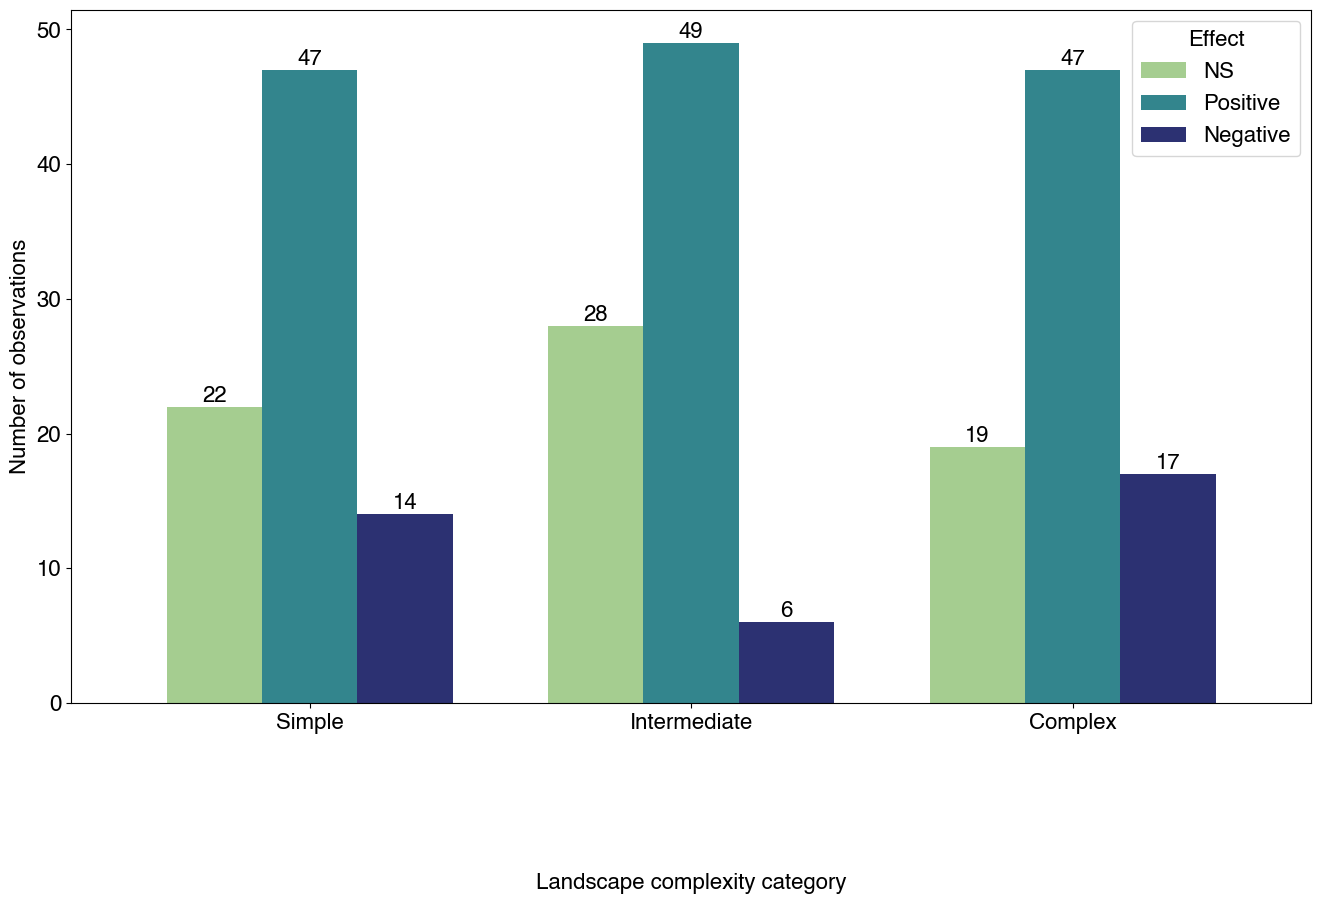

In [44]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 16})

ax11 = (
    interaction_data[["Simple", "Intermediate", "Complex"]]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .plot(
        kind="bar",
        colormap="crest",
        width=0.75,
        #title="Significant local and landscape interaction observations",
        ylabel="Number of observations",
        xlabel="Landscape complexity category",
        rot=0,
        figsize=(16, 9),
    )
)

ax11.xaxis.labelpad = 100

for container in ax11.containers:
    ax11.bar_label(container, fontsize=16)

ax11.legend(title="Effect")


In [45]:
all_interactions = (
    interaction_data[["Simple", "Intermediate", "Complex"]]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

all_interactions


,Simple,Intermediate,Complex
NS,22,28,19
Positive,47,49,47
Negative,14,6,17


In [46]:
stats.chisquare(all_interactions)


Power_divergenceResult(statistic=array([21.42168675, 33.42168675, 20.3373494 ]), pvalue=array([2.23017954e-05, 5.52806238e-08, 3.83531192e-05]))

In [47]:
stats.chisquare(all_interactions.T)


Power_divergenceResult(statistic=array([1.82608696, 0.05594406, 5.24324324]), pvalue=array([0.40130101, 0.97241557, 0.0726849 ]))

In [48]:
arthropod_interactions = (
    interaction_data.where(interaction_data["Response Category"] == "Arthropod")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .fillna(0)
    .T
)

arthropod_interactions


,Simple,Intermediate,Complex
NS,0.0,2.0,0.0
Positive,3.0,2.0,3.0
Negative,1.0,0.0,1.0


In [49]:
stats.chisquare(arthropod_interactions)


Power_divergenceResult(statistic=array([3.5, 2. , 3.5]), pvalue=array([0.17377394, 0.36787944, 0.17377394]))

In [50]:
stats.chisquare(arthropod_interactions.T)


Power_divergenceResult(statistic=array([4.  , 0.25, 1.  ]), pvalue=array([0.13533528, 0.8824969 , 0.60653066]))

In [51]:
stats.chi2_contingency(arthropod_interactions)


Chi2ContingencyResult(statistic=5.250000000000001, pvalue=0.2625941192491615, dof=4, expected_freq=array([[0.66666667, 0.66666667, 0.66666667],
       [2.66666667, 2.66666667, 2.66666667],
       [0.66666667, 0.66666667, 0.66666667]]))

In [52]:
crop_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Crop")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

crop_interaction


,Simple,Intermediate,Complex
NS,4,5,2
Positive,1,4,6
Negative,5,1,2


In [53]:
stats.chisquare(crop_interaction)


Power_divergenceResult(statistic=array([2.6, 2.6, 3.2]), pvalue=array([0.27253179, 0.27253179, 0.20189652]))

In [54]:
stats.chisquare(crop_interaction.T)


Power_divergenceResult(statistic=array([1.27272727, 3.45454545, 3.25      ]), pvalue=array([0.52921334, 0.17776857, 0.19691168]))

In [55]:
stats.chi2_contingency(crop_interaction)


Chi2ContingencyResult(statistic=7.977272727272728, pvalue=0.09241428016463347, dof=4, expected_freq=array([[3.66666667, 3.66666667, 3.66666667],
       [3.66666667, 3.66666667, 3.66666667],
       [2.66666667, 2.66666667, 2.66666667]]))

In [56]:
pollinator_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Pollinator")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

pollinator_interaction


,Simple,Intermediate,Complex
NS,4,6,6
Positive,18,16,13
Negative,2,2,5


In [57]:
stats.chisquare(pollinator_interaction)


Power_divergenceResult(statistic=array([19.  , 13.  ,  4.75]), pvalue=array([7.48518299e-05, 1.50343919e-03, 9.30144892e-02]))

In [58]:
stats.chisquare(pollinator_interaction.T)


Power_divergenceResult(statistic=array([0.5       , 0.80851064, 2.        ]), pvalue=array([0.77880078, 0.66747368, 0.36787944]))

In [59]:
stats.chi2_contingency(pollinator_interaction)


Chi2ContingencyResult(statistic=3.3085106382978724, pvalue=0.5075849533928345, dof=4, expected_freq=array([[ 5.33333333,  5.33333333,  5.33333333],
       [15.66666667, 15.66666667, 15.66666667],
       [ 3.        ,  3.        ,  3.        ]]))

In [60]:
natural_enemy_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Natural enemy")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

natural_enemy_interaction


,Simple,Intermediate,Complex
NS,12,12,9
Positive,21,23,23
Negative,5,3,6


In [61]:
stats.chisquare(natural_enemy_interaction)


Power_divergenceResult(statistic=array([10.15789474, 15.84210526, 13.        ]), pvalue=array([0.00622646, 0.00036302, 0.00150344]))

In [62]:
stats.chisquare(natural_enemy_interaction.T)


Power_divergenceResult(statistic=array([0.54545455, 0.11940299, 1.        ]), pvalue=array([0.76130039, 0.9420457 , 0.60653066]))

In [63]:
stats.chi2_contingency(natural_enemy_interaction)


Chi2ContingencyResult(statistic=1.664857530529172, pvalue=0.7970909556182693, dof=4, expected_freq=array([[11.        , 11.        , 11.        ],
       [22.33333333, 22.33333333, 22.33333333],
       [ 4.66666667,  4.66666667,  4.66666667]]))

In [64]:
pest_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Pest")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
).fillna(0)

pest_interaction


,Simple,Intermediate,Complex
NS,2.0,3.0,2.0
Positive,4.0,4.0,2.0
Negative,1.0,0.0,3.0


In [65]:
stats.chisquare(pest_interaction)

Power_divergenceResult(statistic=array([2.        , 3.71428571, 0.28571429]), pvalue=array([0.36787944, 0.15611805, 0.8668779 ]))

In [66]:
stats.chisquare(pest_interaction.T)

Power_divergenceResult(statistic=array([0.28571429, 0.8       , 3.5       ]), pvalue=array([0.8668779 , 0.67032005, 0.17377394]))

In [67]:
stats.chi2_contingency(pest_interaction)

Chi2ContingencyResult(statistic=4.585714285714285, pvalue=0.3325046205905675, dof=4, expected_freq=array([[2.33333333, 2.33333333, 2.33333333],
       [3.33333333, 3.33333333, 3.33333333],
       [1.33333333, 1.33333333, 1.33333333]]))

In [68]:
intensity_interactions = interaction_data.where(
    interaction_data["Local Strategy"] == "Intensity"
)[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts)

intensity_interactions


,Simple,Intermediate,Complex
Positive,27,21,20
NS,5,13,9
Negative,4,2,7


In [69]:
stats.chisquare(intensity_interactions)


Power_divergenceResult(statistic=array([28.16666667, 15.16666667,  8.16666667]), pvalue=array([7.65043354e-07, 5.08862186e-04, 1.68512013e-02]))

In [70]:
stats.chisquare(intensity_interactions.T)


Power_divergenceResult(statistic=array([1.26470588, 3.55555556, 2.92307692]), pvalue=array([0.53134012, 0.16901332, 0.23187926]))

In [71]:
stats.chi2_contingency(intensity_interactions)


Chi2ContingencyResult(statistic=7.74333836098542, pvalue=0.10144560306176552, dof=4, expected_freq=array([[22.66666667, 22.66666667, 22.66666667],
       [ 9.        ,  9.        ,  9.        ],
       [ 4.33333333,  4.33333333,  4.33333333]]))

In [72]:
structure_interactions = (
    interaction_data.where(interaction_data["Local Strategy"] == "Structure")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .fillna(0)
)

structure_interactions


,Simple,Intermediate,Complex
NS,0.0,1.0,0.0
Negative,1.0,0.0,0.0
Positive,3.0,3.0,4.0


In [73]:
stats.chisquare(structure_interactions)


Power_divergenceResult(statistic=array([3.5, 3.5, 8. ]), pvalue=array([0.17377394, 0.17377394, 0.01831564]))

In [74]:
stats.chisquare(structure_interactions.T)


Power_divergenceResult(statistic=array([2. , 2. , 0.2]), pvalue=array([0.36787944, 0.36787944, 0.90483742]))

In [75]:
stats.chi2_contingency(structure_interactions)


Chi2ContingencyResult(statistic=4.2, pvalue=0.37961492758424376, dof=4, expected_freq=array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [3.33333333, 3.33333333, 3.33333333]]))

In [76]:
floral_interactions = interaction_data.where(
    interaction_data["Local Strategy"] == "Floral"
)[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts)

floral_interactions


,Simple,Intermediate,Complex
NS,12,9,9
Negative,6,2,7
Positive,12,19,14


In [77]:
stats.chisquare(floral_interactions)


Power_divergenceResult(statistic=array([ 2.4, 14.6,  2.6]), pvalue=array([0.30119421, 0.00067554, 0.27253179]))

In [78]:
stats.chisquare(floral_interactions.T)


Power_divergenceResult(statistic=array([0.6       , 2.8       , 1.73333333]), pvalue=array([0.74081822, 0.24659696, 0.42035038]))

In [79]:
stats.chi2_contingency(floral_interactions)


Chi2ContingencyResult(statistic=5.133333333333333, pvalue=0.27388821949831943, dof=4, expected_freq=array([[10., 10., 10.],
       [ 5.,  5.,  5.],
       [15., 15., 15.]]))

In [80]:
diversity_interactions = interaction_data.where(
    interaction_data["Local Strategy"] == "Diversity"
)[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts)

diversity_interactions


,Simple,Intermediate,Complex
NS,5,5,1
Negative,3,2,3
Positive,5,6,9


In [81]:
stats.chisquare(diversity_interactions)


Power_divergenceResult(statistic=array([0.61538462, 2.        , 8.        ]), pvalue=array([0.73514148, 0.36787944, 0.01831564]))

In [82]:
stats.chisquare(diversity_interactions.T)


Power_divergenceResult(statistic=array([2.90909091, 0.25      , 1.3       ]), pvalue=array([0.23350648, 0.8824969 , 0.52204578]))

In [83]:
stats.chi2_contingency(diversity_interactions)


Chi2ContingencyResult(statistic=4.459090909090909, pvalue=0.3474258377291349, dof=4, expected_freq=array([[3.66666667, 3.66666667, 3.66666667],
       [2.66666667, 2.66666667, 2.66666667],
       [6.66666667, 6.66666667, 6.66666667]]))

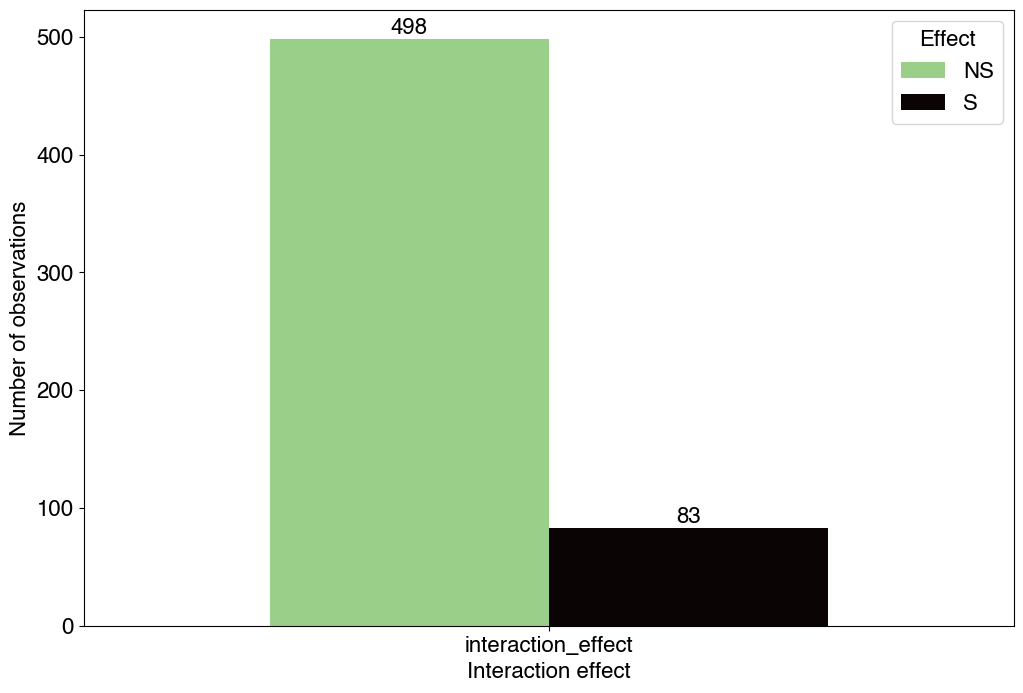

In [176]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 16})

ax11 = lit_review_data[['interaction_effect']].apply(pd.Series.value_counts).T.plot(
        kind="bar",
        color=["#9ACF89", "#0B0405"],
        width=0.75,
        ylabel="Number of observations",
        xlabel="Interaction effect",
        rot=0,
        figsize=(12, 8),
    )

for container in ax11.containers:
    ax11.bar_label(container, fontsize=16)

ax11.legend(title="Effect", labels = ['NS', 'S'])


In [213]:
sig_interactions = lit_review_data.groupby('interaction_effect').count()['response']
sig_interactions

interaction_effect
NS    498
S      83
Name: response, dtype: int64

Text(0, 0.5, 'Number of observations')

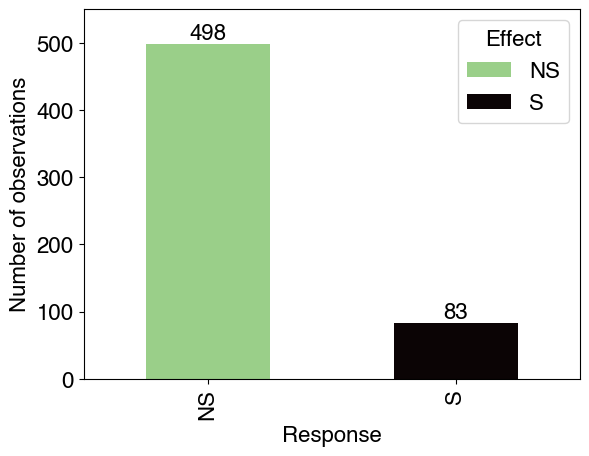

In [219]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 16})

ax = sig_interactions.plot.bar(color=["#9ACF89", "#0B0405"])

for container in ax.containers:
    ax.bar_label(container, fontsize=16)

handles = [
    Patch(facecolor="#9ACF89", label="NS"),
    Patch(facecolor="#0B0405", label="S")
]

plt.legend(title="Effect", handles=handles)
ax.set_ylim(0, 550)
ax.set_xlabel('Response')
ax.set_ylabel('Number of observations')


In [137]:
interaction_data[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts).T[["NS", "Positive", "Negative"]]

,NS,Positive,Negative
Simple,22,47,14
Intermediate,28,49,6
Complex,19,47,17
